In [113]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

In [115]:
df=pd.read_csv('Modified_DS (1).csv')

print(df.head(2))

df.info()

      Scale   Crop   Country Region  latitude  longitude  \
0  Regional  Maize  Pakistan   Asia      31.4       73.1   
1  Regional  Maize  Pakistan   Asia      31.4       73.1   

   CAT(dC)_area_weighted  CAP (mm) _area_weighted   \
0                   25.5                       429   
1                   25.5                       429   

   CAP (mm) _point_coordinate  Future_Mid-point  ...  Irrigation Cultivar  \
0                         429              2054  ...          No       No   
1                         429              2054  ...          No      Yes   

  Soil organic matter management  Planting time  Tillage  Adaptation  \
0                             No             No       No          No   
1                             No            Yes       No         Yes   

   Seasonal P change (mm) each study (LBP)  Base P (annual) (mm) (LBP)  \
0                                      NaN                         NaN   
1                                      NaN                 

In [117]:
df.isnull().sum()

Scale                                         0
Crop                                          0
Country                                       0
Region                                        0
latitude                                      0
longitude                                     0
CAT(dC)_area_weighted                         0
CAP (mm) _area_weighted                       0
CAP (mm) _point_coordinate                    0
Future_Mid-point                              0
Baseline_Mid-point                            1
Time slice                                    0
Climate scenario                              0
Local delta T                              4260
Local delta T from 2005                       0
AP change each study  (mm)                 5005
 AP change  from 2005 (mm)                    0
Projected yield (t/ha)                     5171
Climate impacts (%)                           0
Climate impacts relative to 2005              0
Climate impacts per dC (%)              

In [119]:
df.isnull().mean()*100

Scale                                       0.000000
Crop                                        0.000000
Country                                     0.000000
Region                                      0.000000
latitude                                    0.000000
longitude                                   0.000000
CAT(dC)_area_weighted                       0.000000
CAP (mm) _area_weighted                     0.000000
CAP (mm) _point_coordinate                  0.000000
Future_Mid-point                            0.000000
Baseline_Mid-point                          0.011725
Time slice                                  0.000000
Climate scenario                            0.000000
Local delta T                              49.947239
Local delta T from 2005                     0.000000
AP change each study  (mm)                 58.682143
 AP change  from 2005 (mm)                  0.000000
Projected yield (t/ha)                     60.628444
Climate impacts (%)                         0.

<Figure size 1200x600 with 0 Axes>

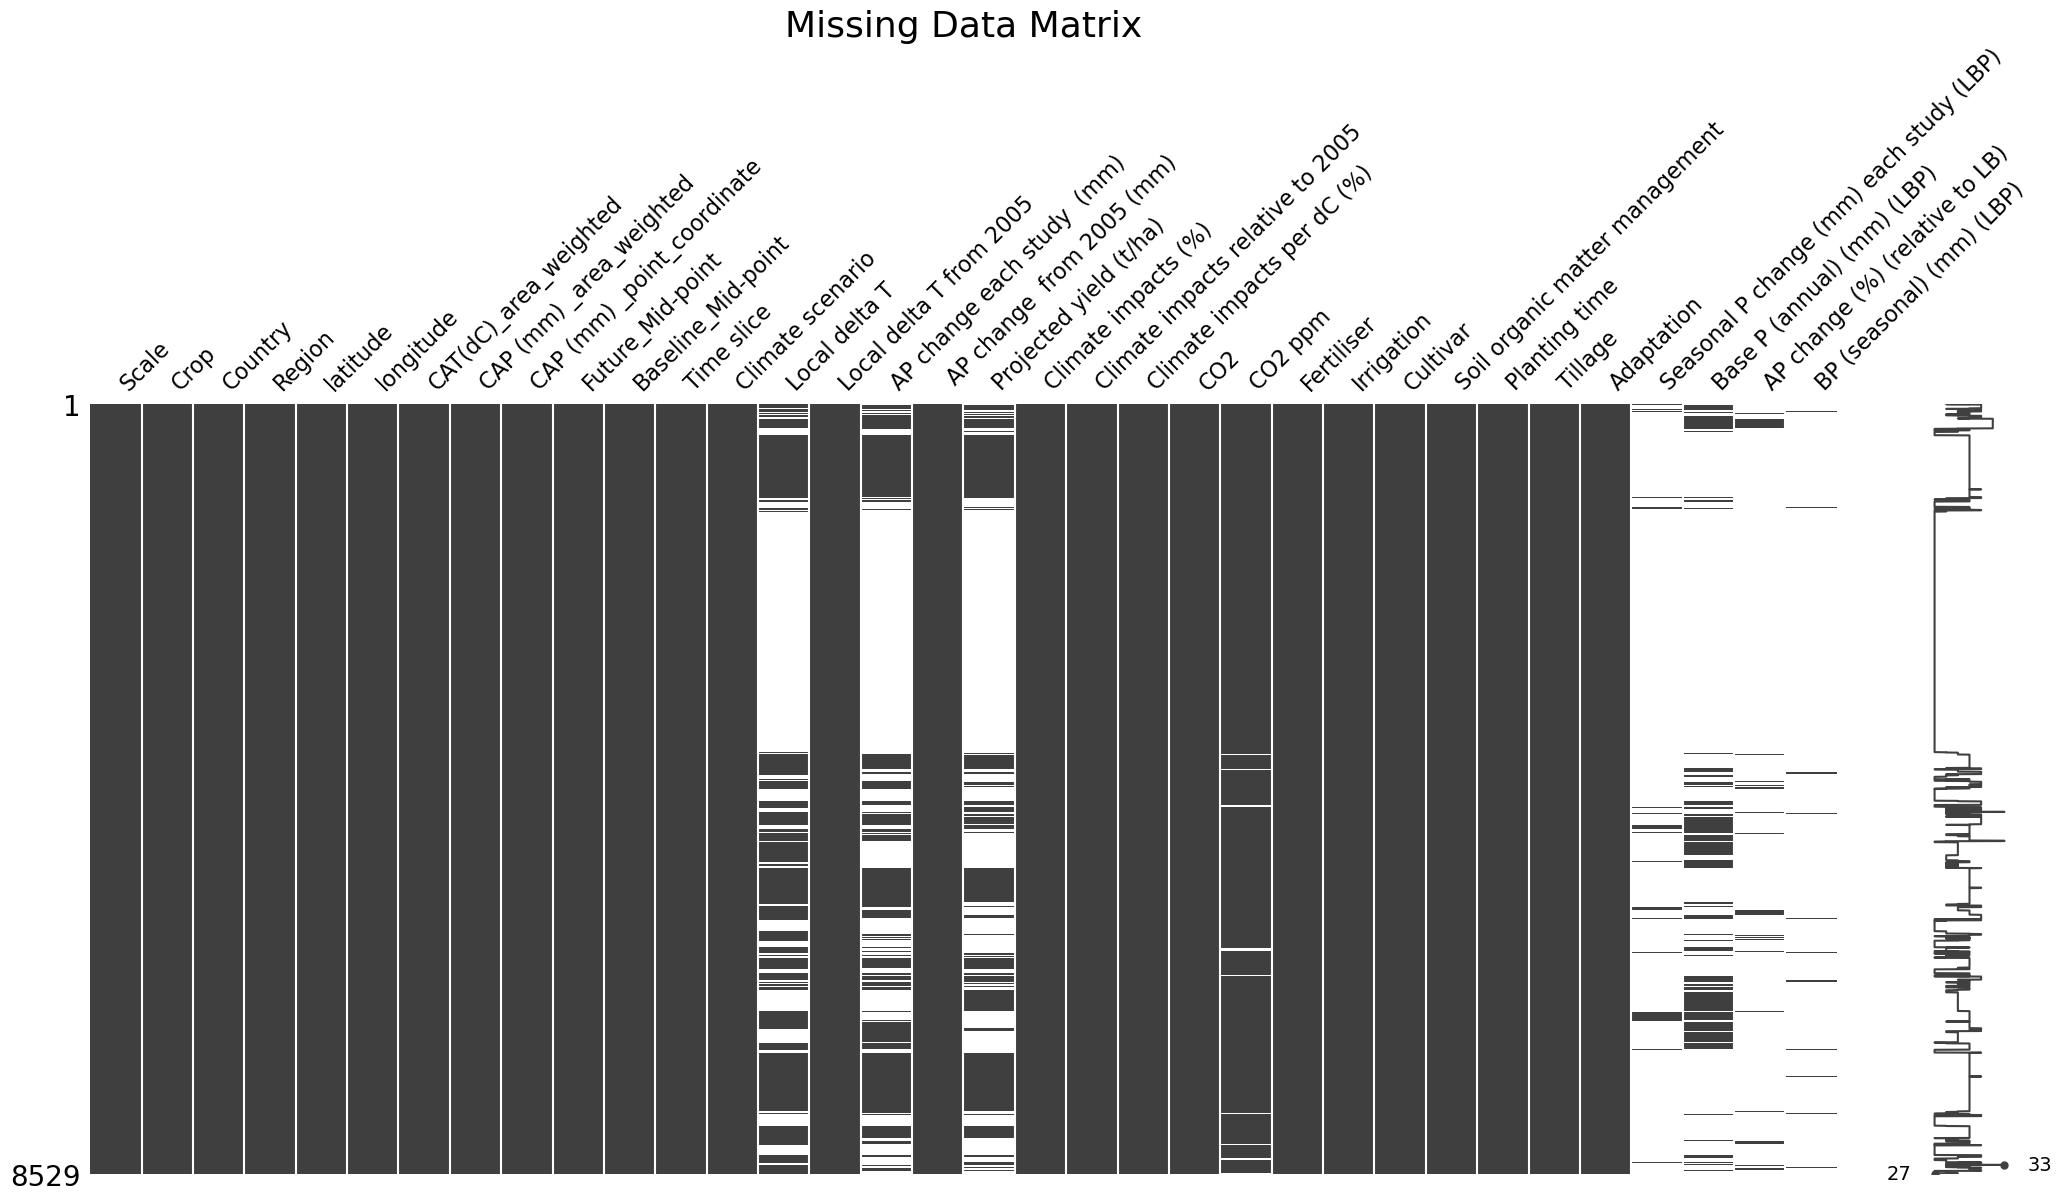

In [121]:
# Missing data matrix (shows patterns of missingness)
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title("Missing Data Matrix", fontsize=26)
plt.show()

In [122]:
df.drop(columns=[
    'Seasonal P change (mm) each study (LBP)',
    'Base P (annual) (mm) (LBP)',
    'AP change (%) (relative to LB)',
    'BP (seasonal) (mm) (LBP)'
], inplace=True)

<Figure size 1200x600 with 0 Axes>

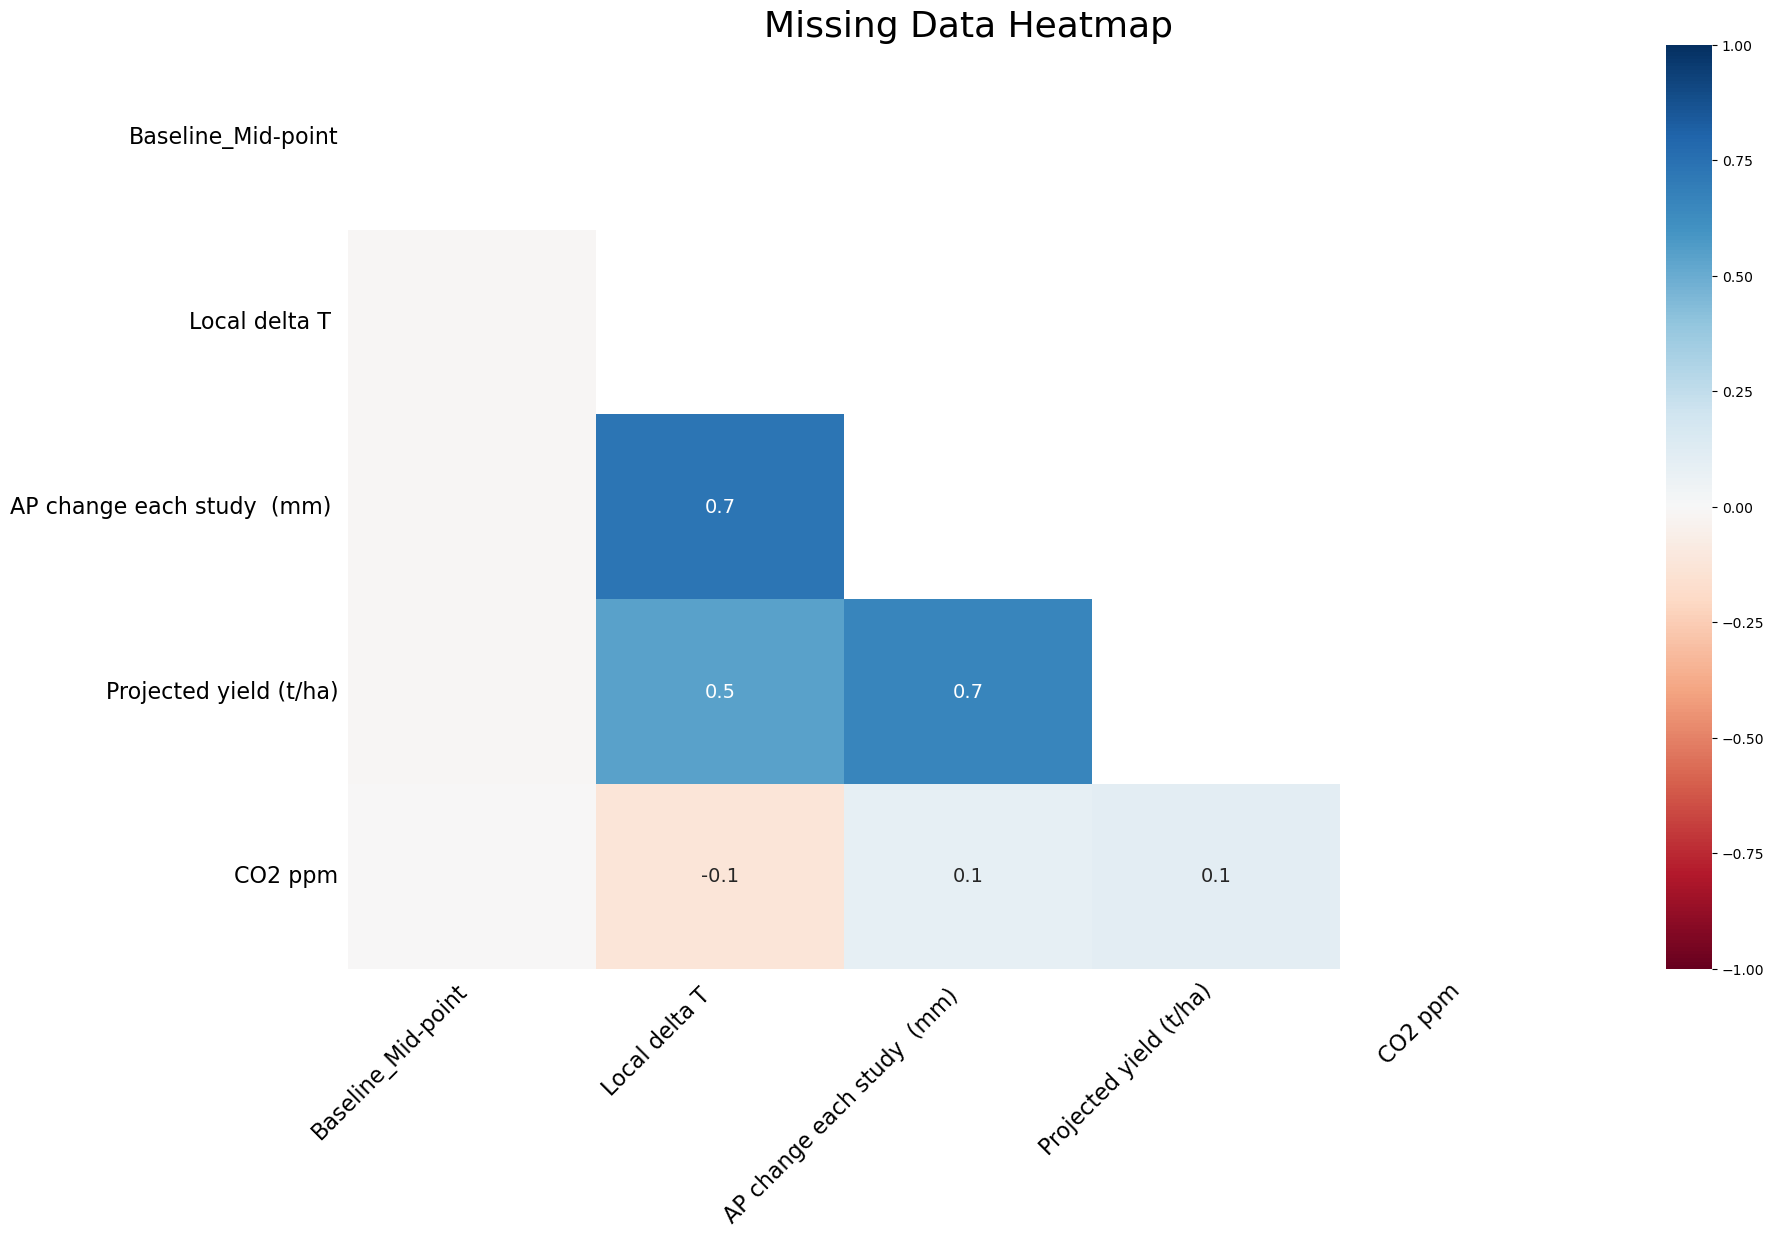

In [123]:
# Missing data heatmap (correlations in missingness)
plt.figure(figsize=(12, 6))
msno.heatmap(df)
plt.title("Missing Data Heatmap", fontsize=26)
plt.show()

In [127]:
#Handling missing values for CO2 & Baseline Mid-point using simple median imputer
df['CO2 ppm'] = df['CO2 ppm'].fillna(df['CO2 ppm'].median())
df['Baseline_Mid-point'] = df['Baseline_Mid-point'].fillna(df['Baseline_Mid-point'].median())

In [131]:
print(df.columns.tolist())

['Scale', 'Crop', 'Country', 'Region', 'latitude', 'longitude', 'CAT(dC)_area_weighted', 'CAP (mm) _area_weighted', 'CAP (mm) _point_coordinate', 'Future_Mid-point', 'Baseline_Mid-point', 'Time slice', 'Climate scenario', 'Local delta T', 'Local delta T from 2005', 'AP change each study  (mm)', 'AP change  from 2005 (mm)', 'Projected yield (t/ha)', 'Climate impacts (%)', 'Climate impacts relative to 2005', 'Climate impacts per dC (%)', 'CO2', 'CO2 ppm', 'Fertiliser', 'Irrigation', 'Cultivar', 'Soil organic matter management', 'Planting time', 'Tillage', 'Adaptation']


In [133]:
df.columns = df.columns.str.strip()

In [137]:
selected_cols = ['Local delta T', 'AP change each study  (mm)', 'Projected yield (t/ha)']
df_numeric_subset = df[selected_cols]

In [139]:
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(df_numeric_subset),
    columns=df_numeric_subset.columns,
    index=df_numeric_subset.index
)

In [141]:
df_test = df_numeric_scaled.copy()

# Mask 10% instead of 5% for better evaluation
np.random.seed(42)
mask = (np.random.rand(*df_test.shape) < 0.10) & (~df_test.isnull())

true_values = df_test[mask]
df_masked = df_test.mask(mask)


In [155]:
errors = []
k_values = [1, 2, 3, 5, 7, 10]

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(df_masked)

    imputed_df = pd.DataFrame(imputed, columns=df_test.columns, index=df_test.index)

    # Compare only at masked positions
    imputed_values = imputed_df[mask]

    # Drop NaNs that could not be imputed
    valid_rows = imputed_values.dropna()
    true_values_clean = true_values.loc[valid_rows.index]

    if len(valid_rows) > 0:
        mse = mean_squared_error(true_values_clean, valid_rows)
        errors.append(mse)
    else:
        print(f"No valid imputed values for k = {k}")
        errors.append(np.nan)


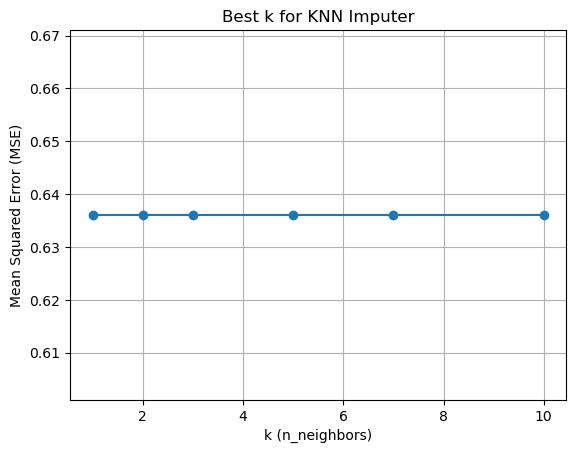

✅ Best k is: 1 with MSE: 0.63607191882949


In [157]:
# Plot the results
plt.plot(k_values, errors, marker='o')
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Best k for KNN Imputer")
plt.grid(True)
plt.show()

# Find best k
valid_errors = [e for e in errors if not np.isnan(e)]
valid_k = [k for k, e in zip(k_values, errors) if not np.isnan(e)]
best_k = valid_k[np.argmin(valid_errors)]
print(f"✅ Best k is: {best_k} with MSE: {min(valid_errors)}")


In [147]:
# Final KNN imputer using best k
final_imputer = KNNImputer(n_neighbors=best_k)
df_imputed_scaled = final_imputer.fit_transform(df_numeric_scaled)

# Convert back to DataFrame
df_imputed_scaled = pd.DataFrame(df_imputed_scaled, columns=df_numeric.columns, index=df_numeric.index)

# Optional: Reverse scaling
df_imputed = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaled),
    columns=df_numeric.columns,
    index=df_numeric.index
)

# Update original DataFrame
df.update(df_imputed)


ValueError: Shape of passed values is (8529, 3), indices imply (8529, 16)

In [153]:
df.isnull().sum()

Scale                                  0
Crop                                   0
Country                                0
Region                                 0
latitude                               0
longitude                              0
CAT(dC)_area_weighted                  0
CAP (mm) _area_weighted                0
CAP (mm) _point_coordinate             0
Future_Mid-point                       0
Baseline_Mid-point                     0
Time slice                             0
Climate scenario                       0
Local delta T                       4260
Local delta T from 2005                0
AP change each study  (mm)          5005
AP change  from 2005 (mm)              0
Projected yield (t/ha)              5171
Climate impacts (%)                    0
Climate impacts relative to 2005       0
Climate impacts per dC (%)             0
CO2                                    0
CO2 ppm                                0
Fertiliser                             0
Irrigation      